# 라이브러리 호출

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import namedtuple # 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있음.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Train

from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# 이미지가 저장된 폴더 경로를 지정합니다. 해당 경로는 Google Drive 내에 있는 폴더여야 합니다.
base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝/데이터 파일/train'

non_demented_folder = 'NonDemented'
verymild_demented_folder = 'VeryMildDemented'
mild_demented_folder = 'MildDemented'
moderate_demented_folder = 'ModerateDemented'

non_demented_image_filepaths = [os.path.join(base_folder_path, non_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, non_demented_folder))]
verymild_demented_image_filepaths = [os.path.join(base_folder_path, verymild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, verymild_demented_folder))]
mild_demented_image_filepaths = [os.path.join(base_folder_path, mild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, mild_demented_folder))]
moderate_demented_image_filepaths = [os.path.join(base_folder_path, moderate_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, moderate_demented_folder))]

# 모든 이미지 파일 경로를 하나의 리스트로 합칩니다.
images_filepaths = [*non_demented_image_filepaths, *verymild_demented_image_filepaths, *mild_demented_image_filepaths, *moderate_demented_image_filepaths]

# 이미지 파일을 읽어올 때 유효한 이미지 파일인지 확인합니다.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# # Test

# test_base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝/데이터 파일/test'

# test_non_demented_folder = 'NonDemented'
# test_verymild_demented_folder = 'VeryMildDemented'
# test_mild_demented_folder = 'MildDemented'
# test_moderate_demented_folder = 'ModerateDemented'

# test_non_demented_image_filepaths = [os.path.join(test_base_folder_path, test_non_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_non_demented_folder))]
# test_verymild_demented_image_filepaths = [os.path.join(test_base_folder_path, test_verymild_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_verymild_demented_folder))]
# test_mild_demented_image_filepaths = [os.path.join(test_base_folder_path, test_mild_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_mild_demented_folder))]
# test_moderate_demented_image_filepaths = [os.path.join(test_base_folder_path, test_moderate_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_moderate_demented_folder))]

# test_images_filepaths = [*test_non_demented_image_filepaths, *test_verymild_demented_image_filepaths, *test_mild_demented_image_filepaths, *test_moderate_demented_image_filepaths]

# test_correct_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]

In [6]:
print(len(correct_images_filepaths))#, len(test_correct_images_filepaths)) # train 데이터셋, test 데이터셋 파일 갯수.

5121


In [7]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:4097] # 0.8% -> train
val_images_filepaths = correct_images_filepaths[4097:] # 0.2% -> validation

# test_images_filepaths = test_correct_images_filepaths
print(len(train_images_filepaths), len(val_images_filepaths))#, len(test_images_filepaths))

4097 1024


# 이미지 데이터 전처리

In [8]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# 변수에 대한 값 정의

In [9]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

# 이미지 데이터 확인

In [10]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

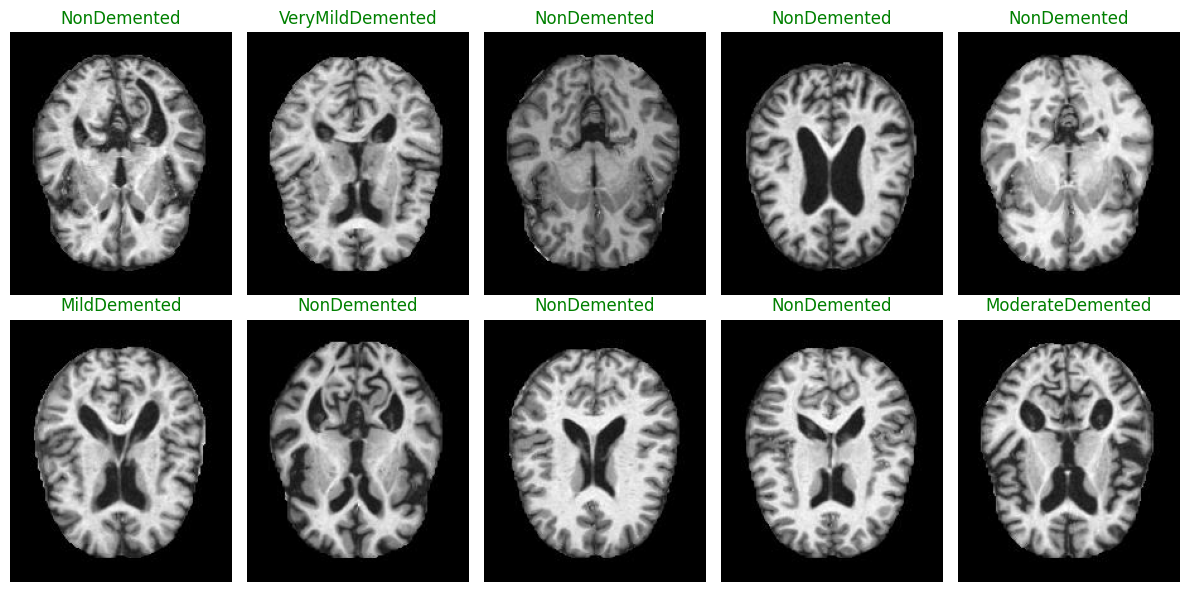

In [11]:
%matplotlib inline

display_image_grid(val_images_filepaths[:10])

# 이미지에 대한 레이블 구분

In [12]:
class alzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):

        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label.startswith('nonDem'):
            label = 0
        elif label.startswith('verymildDem'):
            label = 1
        elif label.startswith('mildDem'):
            label = 2
        elif label.startswith('moderateDem'):
            label = 3
        return img_transformed, label

# 이미지 데이터셋 정의

In [13]:
train_dataset = alzheimerDataset(train_images_filepaths,
                                 transform=ImageTransform(size, mean, std),
                                 phase='train')
val_dataset = alzheimerDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

test_dataset = alzheimerDataset(test_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

index = 0 # index 0의 이미지 크기와 레이블에 대한 출력
print(train_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(test_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(train_dataset.__getitem__(index)[1]) # 0을 의미하기에 Non Demented

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
0


# 데이터셋의 데이터를 메모리로 불러오기

In [14]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0])


In [15]:
import sys
sys.path.append('/content/drive/MyDrive/파이썬 기반 딥러닝')

from ResNet import *
from efficientnet import *
from Coatnet import *

## ResNet Model

In [18]:
# from ResNet import resnet50

# ResNet50 모델 생성
resnet_model = ResNet(resnet50_config, 4)  # num_classes를 원하는 클래스 수로 변경하세요.

# 모델 출력 확인
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottlenect(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Ensemble Model

In [19]:
# class EnsembleModel(nn.Module):
#     def __init__(self, efficientnet, resnet, output_dim):
#         super(EnsembleModel, self).__init__()
#         self.efficientnet = efficientnet
#         self.resnet = resnet
#         self.fc = nn.Linear(output_dim * 2, output_dim)  # output_dim은 최종 클래스 수입니다.
#         self.softmax = nn.Softmax(dim=1)  # Softmax 활성화 함수 추가

#     def forward(self, x):
#         # EfficientNet 및 ResNet의 각각의 forward 호출
#         efficientnet_output = self.efficientnet(x)
#         resnet_output = self.resnet(x)

#         # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
#         if isinstance(efficientnet_output, tuple):
#             efficientnet_output = efficientnet_output[0]

#         if isinstance(resnet_output, tuple):
#             resnet_output = resnet_output[0]

#         # EfficientNet 및 ResNet의 출력을 결합
#         combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

#         # 최종 선형 레이어를 통해 최종 예측 생성
#         final_output = self.fc(combined_output)

#         # Softmax 활성화 함수를 통해 확률 분포로 변환
#         final_output = self.softmax(final_output)

#         return final_output

# # EfficientNet과 ResNet 모델 생성
# efficientnet_model = EfficientNet(num_classes=4)
# resnet_model = ResNet(resnet50_config, 4)

# # 앙상블 모델 생성
# ensemble_model = EnsembleModel(efficientnet_model, resnet_model, 4)

# # 모델 출력 확인
# print(ensemble_model)

# 옵티마이저와 손실 함수 정의

In [22]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 매 30 epoch 마다 학습률을 0.1배로 줄임

In [23]:
# optimizer = optim.AdamW(ensemble_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

resnet_model = resnet_model.to(device)
criterion = criterion.to(device)

# 모델 학습 정확도 측정 함수 정의

In [24]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, dim=1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size

    return acc_1, acc_k

# 모델 학습 함수 정의

In [35]:
from torch.nn.functional import one_hot

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        if isinstance(y_pred, (list, tuple)):
            y_pred = y_pred[0]

        y = one_hot(y, num_classes=4)
        y_indices = torch.argmax(y, dim=1)

        loss = criterion(y_pred, y_indices)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

# 모델 평가 함수 정의

In [44]:
def evaluate(model, iterator, criterion, device, return_predictions=False):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    valid_labels = []
    valid_probs = []

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            if isinstance(y_pred, (list, tuple)):
                y_pred = y_pred[0]

            y = one_hot(y, num_classes=4)
            y_indices = torch.argmax(y, dim=1)

            loss = criterion(y_pred, y_indices)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

            valid_labels.extend(y.cpu().numpy())
            valid_probs.extend(torch.softmax(y_pred, dim=1).cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    if return_predictions:
        return epoch_loss, epoch_acc_1, epoch_acc_5, np.array(valid_labels), np.array(valid_probs)
    else:
        return epoch_loss, epoch_acc_1, epoch_acc_5

# 모델 학습 시간 측정 함수 정의

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))

    return elapsed_mins, elapsed_secs

# 모델 학습

In [48]:
best_valid_loss = float('inf')
EPOCHS = 30

train_accuracy = []
valid_accuracy = []
train_losses = [] # train_loss -> train_losses
valid_losses = [] # valid_loss -> valid_losses

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    t_loss, train_acc_1, train_acc_5 = train(resnet_model, train_iterator, optimizer, criterion, device) # train_loss -> t_loss
    v_loss, valid_acc_1, valid_acc_5, valid_labels, valid_preds = evaluate(resnet_model, valid_iterator, criterion, device, return_predictions=True) # valid_loss -> v_loss

    train_accuracy.append((train_acc_1, train_acc_5))
    valid_accuracy.append((valid_acc_1, valid_acc_5))
    train_losses.append(t_loss) # train_loss.append(train_loss) -> train_losses.append(t_loss)
    valid_losses.append(v_loss) # valid_loss.append(valid_loss) -> valid_losses.append(v_loss)

    scheduler.step()

    if v_loss < best_valid_loss: # valid_loss -> v_loss
        best_valid_loss = v_loss # valid_loss -> v_loss
        torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {t_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
         f'Train Acc @5: {train_acc_5*100:6.2f}%') # train_loss -> t_loss
    print(f'\tValid Loss: {v_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
         f'Valid Acc @5: {valid_acc_5*100:6.2f}%') # valid_loss -> v_loss


Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 0.585 | Train Acc @1:  76.41% | Train Acc @5:  93.53%
	Valid Loss: 0.711 | Valid Acc @1:  76.56% | Valid Acc @5:  92.77%
Epoch: 02 | Epoch Time: 1m 4s
	Train Loss: 0.427 | Train Acc @1:  84.71% | Train Acc @5:  96.61%
	Valid Loss: 0.384 | Valid Acc @1:  85.35% | Valid Acc @5:  97.56%
Epoch: 03 | Epoch Time: 1m 4s
	Train Loss: 0.313 | Train Acc @1:  88.08% | Train Acc @5:  97.75%
	Valid Loss: 0.372 | Valid Acc @1:  85.45% | Valid Acc @5:  97.75%
Epoch: 04 | Epoch Time: 1m 7s
	Train Loss: 0.293 | Train Acc @1:  89.51% | Train Acc @5:  97.84%
	Valid Loss: 0.333 | Valid Acc @1:  87.99% | Valid Acc @5:  97.75%
Epoch: 05 | Epoch Time: 1m 4s
	Train Loss: 0.317 | Train Acc @1:  88.08% | Train Acc @5:  97.63%
	Valid Loss: 0.230 | Valid Acc @1:  91.50% | Valid Acc @5:  98.34%
Epoch: 06 | Epoch Time: 1m 4s
	Train Loss: 0.212 | Train Acc @1:  92.61% | Train Acc @5:  98.98%
	Valid Loss: 0.309 | Valid Acc @1:  90.92% | Valid Acc @5:  97.46%
Epoch: 07 | Epoc

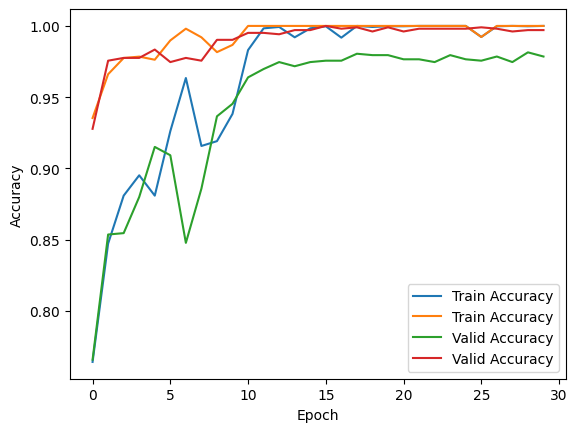

In [49]:
# Plotting train and valid accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

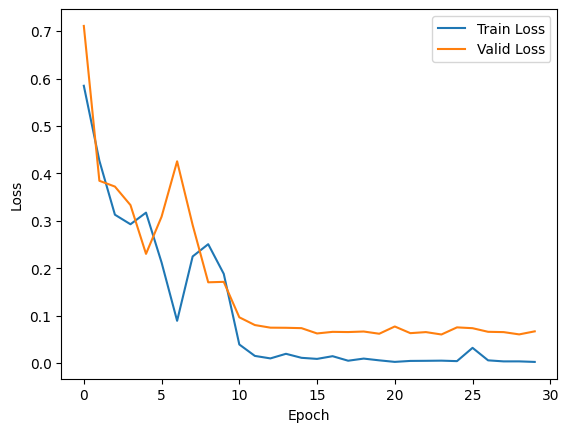

In [50]:
# Plotting train and valid accuracy
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()